## intro

In our bigram model, predictions are not very good as we're taking just one character of context but if we're to take more than one characters, things quickly blowup and the counts table grows exponentially.

for example, when we take 2 characters as the context, the size of count matrix is 27 * 27 = 729 possibilities of context or when we take 3 characters as the context, the size becomes 27 * 27 * 27 = 19683 possibilities of context.

## bengio et al. 2003 (MLP language model) paper walkthrough

## (re-)building our training dataset

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# real all the words
words = open('/kaggle/input/namestxt/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [3]:
# build the vocabulary of characters and mappings to/form integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], [] # X: inputs, Y: labels

for w in words[:5]:
    
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix] # crop and append (rolling window)
        
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
olivia
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
ava
... ----> a
..a ----> v
.av ----> a
ava ----> .
isabella
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
sophia
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


The block size of 3 tells us we are predicting 4th character given 3 characters. We can change the block size to take any number of characters.

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

We have 32 examples and each input to the neural net is 3 integers and the dtype is int64. Y is also 32.

In [7]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [8]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

## implementing the embedding lookup table

In [6]:
C = torch.randn((27, 2))

In [10]:
# one way to get embedding for integer 5
C[5]

tensor([ 0.6149, -0.2383])

In [11]:
# one-hot encoding to encode integer 5
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([ 0.6149, -0.2383])

We're going to use the first one because it is much faster and discard the one-hot encoding interpretation

In [12]:
# pytorch indexing
C[[5, 6, 7]]

tensor([[ 0.6149, -0.2383],
        [ 0.5464,  1.2247],
        [ 1.3600,  0.8270]])

In [13]:
C[torch.tensor([5, 6, 7, 7, 7, 7])]

tensor([[ 0.6149, -0.2383],
        [ 0.5464,  1.2247],
        [ 1.3600,  0.8270],
        [ 1.3600,  0.8270],
        [ 1.3600,  0.8270],
        [ 1.3600,  0.8270]])

In [14]:
# index with multi-dimensional tensor
C[X]

tensor([[[-0.4652,  0.5507],
         [-0.4652,  0.5507],
         [-0.4652,  0.5507]],

        [[-0.4652,  0.5507],
         [-0.4652,  0.5507],
         [ 0.6149, -0.2383]],

        [[-0.4652,  0.5507],
         [ 0.6149, -0.2383],
         [ 1.0150, -0.3974]],

        [[ 0.6149, -0.2383],
         [ 1.0150, -0.3974],
         [ 1.0150, -0.3974]],

        [[ 1.0150, -0.3974],
         [ 1.0150, -0.3974],
         [-0.8334,  0.2520]],

        [[-0.4652,  0.5507],
         [-0.4652,  0.5507],
         [-0.4652,  0.5507]],

        [[-0.4652,  0.5507],
         [-0.4652,  0.5507],
         [ 0.4056, -0.3506]],

        [[-0.4652,  0.5507],
         [ 0.4056, -0.3506],
         [ 0.7256, -0.8017]],

        [[ 0.4056, -0.3506],
         [ 0.7256, -0.8017],
         [ 0.5538, -0.4868]],

        [[ 0.7256, -0.8017],
         [ 0.5538, -0.4868],
         [-0.9410, -0.4225]],

        [[ 0.5538, -0.4868],
         [-0.9410, -0.4225],
         [ 0.5538, -0.4868]],

        [[-0.9410, -0

In [15]:
# for all the (32, 3) integers we've retrieved 2 dimensions emb vector here
C[X].shape

torch.Size([32, 3, 2])

In [16]:
X[13, 2]

tensor(1)

In [17]:
C[X][13, 2]

tensor([-0.8334,  0.2520])

In [18]:
C[1]

tensor([-0.8334,  0.2520])

In [19]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

## implementing hidden layer + internals of torch.Tensor: storage, views

In [20]:
# number of inputs to the hidden layer = 3 words * 2 dimensions
# number of neurons = 100 which is a variable
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [21]:
# Now normally we would like to do the following
# emb @ W1 + b1
# but this won't work because the shape of emb is [32, 3, 2] and W1.shape = [6, 100]

In [22]:
# we need to transform the [32, 3, 2] to [32, 6] to perform the matrix multiplication
# you've got lots and lots of function in pytorch https://pytorch.org/docs/stable/torch.html

# we actually need to concatenate the embeddings of all the 3 words
#emb[:, 0, :].shape # embeddings of just the first word

# takes 3 pieces in a list and concatenate across dimension 1
#torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

# but the above code would not generalize if we have more than 3 blocks
# unbind gives exactly the list of embs

# inefficient and creates new kind of new memory
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

In [23]:
# There's actually a efficient and better way to do this
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [24]:
a.view(2, 9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [25]:
a.view(9, 2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

In [26]:
a.view(3, 3, 2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

To understand view read http://blog.ezyang.com/2019/05/pytorch-internals/

In [27]:
emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [28]:
# instead of hard-coding value of 32 we can use emb.shape[0]
# or we can just use -1 so that pytorch will directly infer what the value should be
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [29]:
# these numbers are now between -1 and 1 because of the tanh
h

tensor([[ 0.6060,  0.9323, -0.8820,  ...,  0.9722,  0.6078, -0.4280],
        [ 0.0282, -0.7114,  0.2957,  ...,  0.2632,  0.7444, -0.9720],
        [ 0.8107, -0.9977,  0.9747,  ...,  0.4998, -0.3805, -0.9980],
        ...,
        [-0.8317, -0.8307,  0.9716,  ..., -0.9429,  0.9570, -0.9764],
        [ 0.9546, -0.9903,  0.9700,  ...,  0.9809, -0.9516, -0.9430],
        [ 0.9639,  0.9592,  0.2876,  ...,  0.8327,  0.9429, -0.5069]])

In [30]:
# 100 activations for every one of our 32 examples
h.shape

torch.Size([32, 100])

In [31]:
# be careful with the broadcasting when there is a addition operator involved
(emb.view(32, 6) @ W1).shape

torch.Size([32, 100])

In [32]:
b1.shape

torch.Size([100])

In [33]:
# broadcasting

# 32, 100
#  1, 100 # adds a fake 1 here

# so that the row vector (1, 100) gets multiplied 32 times and get added with the 32 examples (32, 100)
# so that is the correct thing we're doing here

# ALWAYS A GOOD PRACTICE TO ENSURE ABOUT THIS

## implementing the output layer

In [34]:
W2 = torch.randn((100, 27)) # 27 outputs
b2 = torch.randn(27)

In [35]:
logits = h @ W2 + b2

In [36]:
logits.shape

torch.Size([32, 27])

## implementing the neg log likelihood loss

In [37]:
counts = logits.exp() # fake counts
prob = counts / counts.sum(1, keepdims=True) # normalize them to get probability

In [38]:
prob.shape

torch.Size([32, 27])

In [39]:
# index into prob to pluck out the probability assigned to the correct character as given in Y
prob[torch.arange(32), Y]

tensor([1.1544e-07, 3.5283e-06, 1.2848e-01, 4.7182e-11, 8.0063e-09, 8.3058e-10,
        3.3949e-10, 4.4187e-04, 5.0751e-10, 1.9477e-09, 8.9944e-11, 9.4405e-06,
        2.9419e-10, 2.0229e-04, 5.5582e-10, 2.1856e-11, 6.6793e-01, 2.7178e-07,
        3.7521e-11, 3.7988e-08, 2.0652e-08, 1.2003e-06, 2.0029e-04, 1.0874e-10,
        2.9807e-06, 7.0587e-12, 5.8175e-12, 7.1040e-08, 6.7528e-13, 5.8867e-05,
        1.3523e-04, 6.8412e-05])

some of the numbers look very small and the nn thinks those are very unlikely but we haven't trained this network as of now so this will improve and ideally these numbers should be 1.0

In [40]:
loss = -prob[torch.arange(32), Y].log().mean()

In [41]:
loss

tensor(16.6344)

This loss we would like to minimize to correctly predict the next character in the sequence

## summary of the full network

In [42]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [43]:
g = torch.Generator().manual_seed(24)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [44]:
# total parameters
sum(p.nelement() for p in parameters)

3481

In [45]:
# foward pass
emb = C[X] # (32, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2

# pytorch creates these new intermediate tensors and is very inefficient
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.6649)

## introducing cross_entropy and why?

In [46]:
# pytorch has much more efficient function to do above things
# uses fused kernels and cross_entropy is mathematically much more simple to do the backward pass
loss = F.cross_entropy(logits, Y)
loss

tensor(17.6649)

In [47]:
# also cross_entropy creates numbers that are well behaved
# les look at an example

logits = torch.tensor([-2.0, -1.0, 0.0, 3.0])
counts = logits.exp()
prob = counts / counts.sum()
prob

# decent and well behaved numbers

tensor([0.0063, 0.0170, 0.0463, 0.9304])

In [48]:
# but when we get logits of extreme +ve numbers
logits = torch.tensor([-2.0, -1.0, 0.0, 100.0])
counts = logits.exp() # e^100 makes it run out of range
prob = counts / counts.sum()
prob

# these numbers start getting worse because exp() of very +ve number is 'inf' as we run of range in our floating point numbers

tensor([0., 0., 0., nan])

In [49]:
# because of the normalization we can actually offset any values in the logits as we want
# and the result will be exactly the same
logits = torch.tensor([-2.0, -1.0, 0.0, 5.0]) -3 # +1, +2, -3

# because -ve numbers are ok and +ve numbers can overflow
# so pytorch internally calculates the maximum number from the logits and substracts it
# so the greatest number will become 0.0 and all the other numbers will become somewhat -ve
# and result of this will always be well behaved
logits = torch.tensor([-2, -1, 0, 100]) - 100
counts = logits.exp()
prob = counts / counts.sum()
prob

tensor([5.6052e-45, 1.4013e-44, 3.7835e-44, 1.0000e+00])

why use cross_entropy?
1. forward pass is much more efficient
2. backward pass is much more efficient
3. the numbers that come out are well behaved 

## implementing training loop, overfitting one batch

In [50]:
for p in parameters:
    p.requires_grad = True

In [51]:
for _ in range(100):
    # foward pass
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2

    # pytorch creates these new intermediate tensors and is very inefficient
    loss = F.cross_entropy(logits, Y)

    # backward pass
    for p in parameters:
        p.grad = None # same as setting it to 0.0 in pytorch

    loss.backward() # set requires_grad = True as above orelse it will return an error

    # update
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

0.3344168961048126


We're just overfitting a single batch of data that has just 32 examples

In [52]:
logits.max(1) # max values and indices along the 1st dimension

torch.return_types.max(
values=tensor([11.7862, 12.4928, 12.6971, 12.9874, 15.2763, 11.7862, 10.5448, 17.9373,
        16.7310, 10.2932, 22.9460, 17.8582, 11.7862,  8.4837, 11.5802, 16.8019,
        11.7862, 14.2435, 12.1441, 14.2817, 13.2357, 13.2238,  9.4367, 16.8137,
        10.3680, 11.7862, 10.1866, 11.6999, 13.5402, 13.5334, 16.7169, 11.9477],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [53]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

You can see that the indices are very close to labels but we haven't been able to get a 0 loss and thats because in our training set '...' is suppose to predict 'e', also '...' is suppose to predict 'o' and so on. So basically e, o, i, etc are all possible outcomes in a training set. Our model only overfits and predicts correctly on data which has unique input and unique output.

## training on the full dataset, minibatches

In [54]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], [] # X: inputs, Y: labels

for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append (rolling window)
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [55]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [56]:
g = torch.Generator().manual_seed(24)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [57]:
# total parameters
sum(p.nelement() for p in parameters)

3481

In [58]:
for p in parameters:
    p.requires_grad = True

In [59]:
for _ in range(10):
    
    # minibatch
    ix = torch.randint(0, X.shape[0], (32, ))
    
    # foward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (100, 27)

    # pytorch creates these new intermediate tensors and is very inefficient
    loss = F.cross_entropy(logits, Y[ix])
    
    print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None # same as setting it to 0.0 in pytorch

    loss.backward() # set requires_grad = True as above orelse it will return an error

    # update
    for p in parameters:
        p.data += -0.1 * p.grad

15.698527336120605
15.03404712677002
12.231035232543945
13.634437561035156
10.445084571838379
12.056876182556152
9.742308616638184
9.242391586303711
9.373602867126465
11.35256290435791


It is taking a lot of time to process (forward, backward) these 228146 examples. In practice, forward and backward passes are done on minibatches of data

In [60]:
# creates 32 integers that can index into our dataset
torch.randint(0, X.shape[0], (32, ))

tensor([167387, 143073,  19273,   9942, 183505,  12816, 144220,  42386, 191332,
         76435, 127984,  82404, 102882,  60532,  95172, 145497, 223632,  62106,
         59969,  71875, 117154, 178114, 141035, 220763, 104504, 116327, 164169,
        135193,  72416, 169776, 164262,  13743])

as we're using minibatches the quality of our gradient is lower. so the direction of the gradient is not reliable, its not the actual gradient direction. but the gradient direction is good enough that it is useful.

so it is much more efficient to get approximate gradient and take much more steps than to get exact gradient and fewer steps.

## finding a good initial learning rate

try to take some estimates first where the loss explodes and the optimization is unstable and where the loss reduces very slowly

In [61]:
# learning rates
lre = torch.linspace(-3, 0, 1000) # stepping linearly between 0.001 and 1.0
lrs = 10 ** lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [62]:
lri = []
lossi = []

for i in range(1000):
    
    # minibatch
    ix = torch.randint(0, X.shape[0], (32, ))
    
    # foward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (100, 27)

    # pytorch creates these new intermediate tensors and is very inefficient
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:
        p.grad = None # same as setting it to 0.0 in pytorch

    loss.backward() # set requires_grad = True as above orelse it will return an error

    # update
    lr = lrs[i]
    
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())

# print(loss.item())

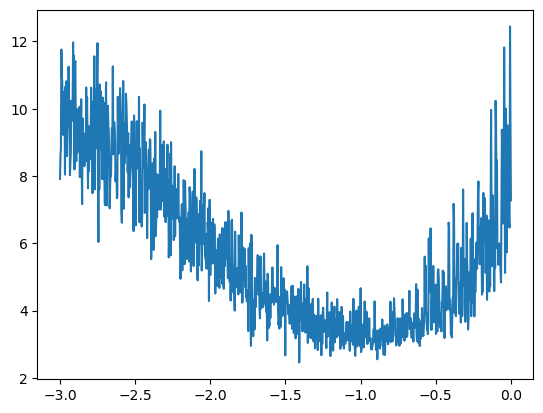

In [63]:
plt.plot(lri, lossi)

often you'll find that your loss will look like this. Initially you had very low learning rate and basically nothing happened and when we increased the learning rate enough things started to become unstable here

so a good learning rate turns out to be somewhere near the elbow point maybe at -1.0 so 0.1 is a fairly good learning rate

In [64]:
for i in range(10000):
    
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32, ))
    
    # foward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (100, 27)

    # pytorch creates these new intermediate tensors and is very inefficient
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:
        p.grad = None # same as setting it to 0.0 in pytorch

    loss.backward() # set requires_grad = True as above orelse it will return an error

    # update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
        
print(loss.item())

2.776238203048706


The bigram model had a loss of 2.45. so we've already surpassed the bigram model.

Lets do the learning rate decay and make the learning rate 10x lower to 0.01 so that at the later stages of training the step size is lower

In [65]:
for i in range(10000):
    
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32, ))
    
    # foward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (100, 27)

    # pytorch creates these new intermediate tensors and is very inefficient
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:
        p.grad = None # same as setting it to 0.0 in pytorch

    loss.backward() # set requires_grad = True as above orelse it will return an error

    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
print(loss.item())

2.5242486000061035


## summary of learning rate estimate

1. you start with a decent learning rate using the approach andrej shows us
2. you start with that learning rate and you train for a while
3. at the end do a learning rate decay

## splitting up the dataset into train/val/test and why

we said that we've a better model than the bigram one because we're achieving a lower loss but it is not exactly true.

the reason that it is not true is that these models can get larger and larger if you keep adding neurons and as the capacity of the neural network grows if becomes more and more capable of overfitting your training set

what that means is that the loss on the training set will reduce to even 0 but all that the model is doing is memorizing the examples in training set and it will only give data from training set and will not give any new data

and if you try to evaluate the loss on some withheld names, you'll see the loss on those will be very high and basically it is not a good model

so practice is to split your dataset into 3 parts:
1. train 80%
2. dev/validation 10%
3. test 10%

- the train set can be used to optimize the parameters of the model (just as we did above)
- val set is used for the development of all the hyperparameters of the model
- test set is used to evaluate the performance of the model at the end (whenever you evaluate your model on test loss and you learn something from it, you're basically starting to also train on your test split. so use it very very few times orelse you risk to overfit  your model on test as well)

In [4]:
# build the dataset

def build_dataset(words):

    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], [] # X: inputs, Y: labels

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append (rolling window)
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [67]:
# train examples
n1

25626

In [68]:
# dev/val examples
n2 - n1

3203

In [69]:
# test examples
len(words) - n2

3204

In [87]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [88]:
g = torch.Generator().manual_seed(24)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [89]:
sum(p.nelement() for p in parameters)

10281

In [90]:
for p in parameters:
    p.requires_grad = True

In [ ]:
lri = []
stepi = []
lossi = []

In [114]:
for i in range(30000):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    
    # foward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 300)
    logits = h @ W2 + b2 # (300, 27)

    # pytorch creates these new intermediate tensors and is very inefficient
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None # same as setting it to 0.0 in pytorch

    loss.backward() # set requires_grad = True as above orelse it will return an error

    # update
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.item())
        
print(loss.item())

1.9255828857421875


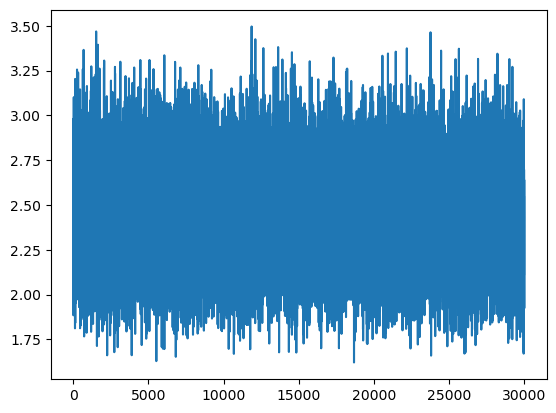

In [115]:
plt.plot(stepi, lossi)

In [116]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (100, 27)
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.41296648979187

train and dev loss are very similar which means we're not overfitting. basically we're underfitting.

maybe increase the hidden layers number of neurons from 100 to 300.

## experiment: larger hidden layer

before the model was underfitting so we expect that increasing the model size will improve the loss.

the reason could be that we have increased the neurons in the hidden layer but maybe the bottleneck maybe the embeddings that 2 dimensional. we're maybe cramming way many characters in 2 dimensional and the networks is not able to use that space effectively. 

## visualize the character embeddings

we're unable to improve much and maybe the bottlenect is the dimensions of embedding layer. We'll visualize them before increasing the dimension from 2. 

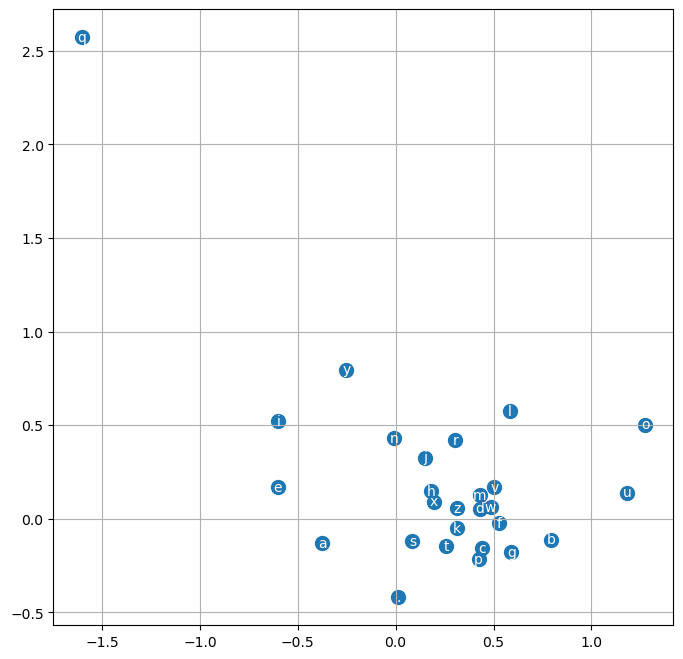

In [117]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:,1].data, s=100)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

## expriment: larger embedding size

In [8]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [9]:
g = torch.Generator().manual_seed(24)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [10]:
sum(p.nelement() for p in parameters)

11897

In [11]:
for p in parameters:
    p.requires_grad = True

In [142]:
stepi = []
lossi = []

In [148]:
for i in range(50000):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    
    # foward pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (200, 27)

    # pytorch creates these new intermediate tensors and is very inefficient
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None # same as setting it to 0.0 in pytorch

    loss.backward() # set requires_grad = True as above orelse it will return an error

    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item()) # log-loss as when you plot loss it has hockey stick kind of visualization and log squashes it
        
print(loss.item())

2.413684844970703


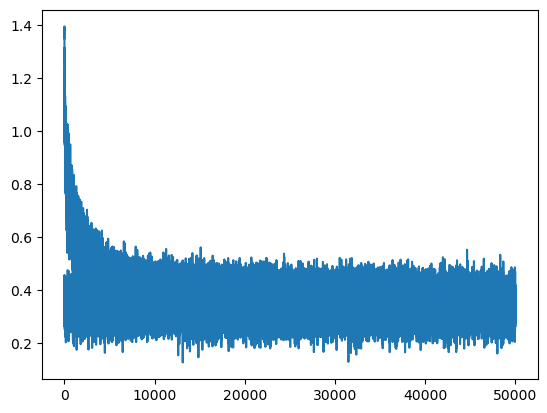

In [149]:
plt.plot(stepi, lossi)

Its again very thick because the minibatch size is very small

In [150]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (100, 27)
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.1548402309417725

In [151]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (100, 27)
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.176633596420288

We're still not sure if we have picked right learning rate and in production you have lots of settings of hyperparameters and you run experiments

Now you can see the training loss and the validation loss are slowly starting to depart and maybe maybe we're slowly starting to overfit

So in production you basically do these experiments with different hyperparameters and once you get the best settings, you take that model and evaluate the loss on the test set and note it down on the paper/brag about it :P

Now we can furthur improve this model by tuning it more or by increasing the input size (right now we're taking 3 characters and maybe we can more as input)

## summary of our full code, conclusion

In [12]:
stepi = []
lossi = []

In [13]:
for i in range(200000):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    
    # foward pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (200, 27)

    # pytorch creates these new intermediate tensors and is very inefficient
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None # same as setting it to 0.0 in pytorch

    loss.backward() # set requires_grad = True as above orelse it will return an error

    # update
    lr = 0.11 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item()) # log-loss as when you plot loss it has hockey stick kind of visualization and log squashes it
        
print(loss.item())

2.0603785514831543


In [14]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (100, 27)
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.0992591381073

In [15]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (100, 27)
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.142148017883301

you can furthur improve this loss by:
1. changing the size of hidden layer
2. changing the dimensionality of the embedding layer
3. increasing the number of characters that are fed in as an input
4. epochs
5. learning rate and learning rate decay
6. batch size

## sampling from the model

In [17]:
block_size = 3
g = torch.Generator().manual_seed(24 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size
    
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out))

eubalde.
erre.
kalyla.
kwaland.
han.
maellia.
hamero.
ardi.
stan.
luch.
menixo.
khalia.
strf.
dra.
beck.
liya.
mearlechance.
kailynnlee.
cahemmerricrin.
jae.


The predicted words are sounding more name like and we're definitely making progress here